# **ECON 585 Final Project**
### By Peterson, Seth and Vorkink, Eric

## **SECTION 0:** Setting Up Development Environment

In [79]:
# The FamaData class was created by Seth Peterson for purpose of the 588 Project
from fama_data.FamaData import FamaData

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from warnings import filterwarnings
filterwarnings('ignore')

## **SECTION 1:** Importing and Gathering Data

#### Section 1a: Testing Portfolios

In [80]:
# Our first testing portfolios
# Equal-weighted momentum portfolios

url = 'http://diether.org/prephd/10-port_mom_ew.csv'
port = pd.read_csv(url,parse_dates=['caldt'])
port = port.query('caldt >= "1963-07-31" and caldt <= "2023-02-28"')

#### Section 1b: Ken French Data Library Zero Cost Portfolios

In [81]:
# Initialize FamaData object
fd = FamaData('data/', end_date = '2022-09-30')

In [82]:
# Compute all non-standard factors from Fama and French data library using FamaData object

share_issue_delta = fd.get_net_share_issue_data()['Hi 10'] - fd.get_net_share_issue_data()['Lo 10']

shortterm_rev_delta = fd.get_shortterm_reversal_data()['Hi PRIOR'] - fd.get_shortterm_reversal_data()['Lo PRIOR']
longterm_rev_delta = fd.get_longterm_reversal_data()['Hi PRIOR'] - fd.get_longterm_reversal_data()['Lo PRIOR']

# Two industry factors that we build by hand
service_minus_goods = 2 * fd.get_49_industry_data()['PerSv'] + 2 * fd.get_49_industry_data()['BusSv'] \
                    + fd.get_49_industry_data()['Softw'] + fd.get_49_industry_data()['Insur'] \
                    + fd.get_49_industry_data()['Fins'] + fd.get_49_industry_data()['Banks'] \
                    - fd.get_49_industry_data()['Hshld'] - fd.get_49_industry_data()['BldMt'] \
                    - fd.get_49_industry_data()['ElcEq'] - fd.get_49_industry_data()['Aero'] \
                    - fd.get_49_industry_data()['Food '] - fd.get_49_industry_data()['Oil'] \
                    - 2 * fd.get_49_industry_data()['Whlsl']

needs_minus_wants = fd.get_49_industry_data()['Food '] + fd.get_49_industry_data()['Util'] \
                    + fd.get_49_industry_data()['Hlth '] + fd.get_49_industry_data()['MedEq'] \
                    + fd.get_49_industry_data()['Drugs'] + fd.get_49_industry_data()['Insur'] \
                    - fd.get_49_industry_data()['Guns'] - fd.get_49_industry_data()['Softw'] \
                    - fd.get_49_industry_data()['Autos'] - fd.get_49_industry_data()['Whlsl'] \
                    - 2*fd.get_49_industry_data()['Hshld']


accrual_delta = fd.get_accrual_data()['Hi 10'] - fd.get_accrual_data()['Lo 10']
cashflow_price_delta = fd.get_cashflow_price_data()['Hi 10'] - fd.get_cashflow_price_data()['Lo 10']
market_beta_delta = fd.get_market_beta_data()['Hi 10'] - fd.get_market_beta_data()['Lo 10']
dividend_yield_delta = fd.get_dividend_yield_data()['Hi 10'] - fd.get_dividend_yield_data()['Lo 10']
earnings_price_delta = fd.get_earnings_price_data()['Hi 10'] - fd.get_earnings_price_data()['Lo 10']
variance_delta = fd.get_variance_data()['Hi 10'] - fd.get_variance_data()['Lo 10']


share_issue_delta.name = 'share_issue_delta'
shortterm_rev_delta.name = 'shortterm_rev_delta'
longterm_rev_delta.name = 'longterm_rev_delta'
service_minus_goods.name = 'service_minus_goods'
needs_minus_wants.name = 'needs_minus_wants'
accrual_delta.name = 'accrual_delta'
cashflow_price_delta.name = 'cashflow_price_delta'
market_beta_delta.name = 'market_beta_delta'
dividend_yield_delta.name = 'dividend_yield_delta'
earnings_price_delta.name = 'earnings_price_delta'
variance_delta.name = 'variance_delta'

In [83]:
# Gather the standard Fama-French factors from the FamaData object

# NOTE TO READER: The FamaData object has a method called get_excess_return_data() that returns the excess returns
# This function is dependent on the python package `getFamaFrenchFactors`
# If you do not have this package installed, you can install it using the command `pip install getFamaFrenchFactors`

excess_returns = fd.get_excess_return_data()['exmt']

SMB_proxy = fd.get_size_data()['Hi 10'] - fd.get_size_data()['Lo 10']
HML_proxy = fd.get_book_to_market_data()['Hi 10'] - fd.get_book_to_market_data()['Lo 10']
RMW_proxy = fd.get_operating_profitability_data()['Hi 10'] - fd.get_operating_profitability_data()['Lo 10']
CMA_proxy = fd.get_investment_data()['Hi 10'] - fd.get_investment_data()['Lo 10']
MOM_proxy = fd.get_momentum_data()['Hi PRIOR'] - fd.get_momentum_data()['Lo PRIOR']

SMB_proxy.name = 'SMB'
HML_proxy.name = 'HML'
RMW_proxy.name = 'RMW'
CMA_proxy.name = 'CMA'
MOM_proxy.name = 'MOM'

In [84]:
# Reset the indices of all the dataframes to be the same; this is necessary for concatenation
# Also, generate two dataframes: one with the alternative factors and one with the standard factors

for x in [share_issue_delta, shortterm_rev_delta, longterm_rev_delta, 
                service_minus_goods, needs_minus_wants, accrual_delta, 
                cashflow_price_delta, market_beta_delta, dividend_yield_delta, 
                earnings_price_delta, variance_delta]:
    x.reset_index(drop=True, inplace=True)

for x in [excess_returns, SMB_proxy, HML_proxy, RMW_proxy, CMA_proxy, MOM_proxy]:
    x.reset_index(drop=True, inplace=True)

# Create a dataframe with all the data
alt_factor_df = pd.concat([port['caldt'].reset_index(drop = 'True'), excess_returns, share_issue_delta, 
                           shortterm_rev_delta, longterm_rev_delta, service_minus_goods, needs_minus_wants, 
                           accrual_delta, cashflow_price_delta, market_beta_delta, dividend_yield_delta, 
                           earnings_price_delta], axis=1)

standard_factor_df = pd.concat([port['caldt'].reset_index(drop = 'True'), excess_returns, SMB_proxy, 
                                HML_proxy, RMW_proxy, CMA_proxy, MOM_proxy], axis=1)

In [85]:
alt_factor_df.head(3)

,caldt,exmt,share_issue_delta,shortterm_rev_delta,longterm_rev_delta,service_minus_goods,needs_minus_wants,accrual_delta,cashflow_price_delta,market_beta_delta,dividend_yield_delta,earnings_price_delta
0,1963-07-31,-0.39,2.09,-0.16,-1.34,-111.46,3.93,-2.52,1.30,-2.13,0.15,-0.26
1,1963-08-30,5.07,1.55,-0.64,0.52,-119.26,2.11,0.04,0.49,6.95,-1.70,0.24
2,1963-09-30,-1.57,-1.86,-0.89,2.00,-97.15,-2.90,1.65,-1.94,-0.58,0.34,-1.93


In [86]:
standard_factor_df.head(3)

,caldt,exmt,SMB,HML,RMW,CMA,MOM
0,1963-07-31,-0.39,0.55,-2.66,2.42,3.07,2.98
1,1963-08-30,5.07,2.67,1.67,0.54,2.32,3.23
2,1963-09-30,-1.57,-0.73,-1.77,2.05,-1.02,1.16


#### Section 1c: 36-Factor Interaction Portfolios (TO BE LASSO'D LATER)

In [87]:
# Pull out the 10 industry factors from the FamaData object
# NOTE TO READER: There are 9 factors (10 industries minus 1 industry that is the other category)
#                 We compute 9^2 = 81 pairwise differences between the 9 factors
#                 Then, we ignore the 9 factors that are the same (e.g. the difference between the "HiTec" industry and the "HiTec" industry)
#                 Lastly, we divide by 2 to account for double-counting (e.g. the difference between the "HiTec" industry and the "Autos" industry 
#                                                             is the same as the difference between the "Autos" industry and the "HiTec" industry)
#                 This leaves us with 36 pairwise differences between the 9 factors (72 / 2 = 36)

factor_port = fd.get_10_industry_data()
cols = factor_port.columns[:-2] # Ignore caldt and Other

many_factor_df = pd.DataFrame(columns = ['caldt'])
many_factor_df['caldt'] = factor_port['caldt']

# Avoid double-counting factors
for i, col_i in enumerate(cols):
    for j, col_j in enumerate(cols):
        if i < j:
            many_factor_df[cols[i].strip() + 'Minus' + cols[j].strip()] = factor_port[cols[i]] - factor_port[cols[j]]

In [88]:
many_factor_df.head(3)

,caldt,NoDurMinusDurbl,NoDurMinusManuf,NoDurMinusEnrgy,NoDurMinusHiTec,NoDurMinusTelcm,NoDurMinusShops,NoDurMinusHlth,NoDurMinusUtils,DurblMinusManuf,...,HiTecMinusTelcm,HiTecMinusShops,HiTecMinusHlth,HiTecMinusUtils,TelcmMinusShops,TelcmMinusHlth,TelcmMinusUtils,ShopsMinusHlth,ShopsMinusUtils,HlthMinusUtils
0,1963-07-31,-0.27,0.91,-2.78,0.20,-0.24,0.56,-1.05,-1.29,1.18,...,-0.44,0.36,-1.25,-1.49,0.80,-0.81,-1.05,-1.61,-1.85,-0.24
1,1963-08-31,-1.66,-1.32,0.95,-0.25,0.60,-1.55,-4.67,0.69,0.34,...,0.85,-1.30,-4.42,0.94,-2.15,-5.27,0.09,-3.12,2.24,5.36
2,1963-09-30,-1.45,-0.92,1.95,-1.82,-4.06,-2.62,2.37,0.81,0.53,...,-2.24,-0.80,4.19,2.63,1.44,6.43,4.87,4.99,3.43,-1.56


#### Section 1d: Creating own value-weighted factor portfolios using CRSP-Compustat merged accounting data

In [89]:
# Create 6 value-weighted factor portfolios built from accounting data
# Data provided by CRSP-Computstat Merged Database

df = pd.read_csv('data/cst.csv').drop(['fyear', 'gvkey'], axis = 1)
df['caldt'] = pd.to_datetime(df['caldt'])

"""
HAND-MADE ACCOUNTING RATIOS:
A portfolio of stocks with high interest, advertising, and research and development expenses relative to their assets
xint       interest expense
xad        advertising expense
xrd        research and development expense
at         total assets
invst      (xint + xad + xrd) / at

A portfolio of efficient firms in terms of their cost of goods sold, and their sales and administrative expenses relative to their assets
cogs       cost of goods sold
xsga       selling, general, and administrative expense
effc       (at - cogs - xsga) / at


STANDARD ACCOUNTING RATIOS:
Quick Ratio:
act        current assets - total
invt       inventories - total
lct        current liabilities - total
quick      (act - invt) / lct

Return on Equity:
revt       revenue - total
xint       interest expense
xad        advertising expense
xrd        research and development expense
xsga       selling, general, and administrative expense
seq        stockholders equity - total
roe        (revt - xint - xad - xrd - xsga) / seq

Fixed Asset Turnover:
act        current assets - total
at         total assets
fat        revt / (at - act)

Debt Ratio:
dltt         long-term debt
dlc          current liabilities
at           total assets
debt_ratio   (dltt + dlc) / at
"""

df['invst'] = (df['xint'] + df['xad'] + df['xrd']) / df['at']
df['effc'] = (df['at'] - df['cogs'] - df['xsga']) / df['at']
df['quick'] = (df['act'] - df['invt']) / df['lct']
df['roe'] = (df['revt'] - df['xint'] - df['xad'] - df['xrd'] - df['xsga']) / df['seq']
df['fat'] = df['revt'] / (df['at'] - df['act'])
df['debt_ratio'] = (df['dltt'] + df['dlc']) / df['at']

In [90]:
# Place accounting ratios into a dataframe and lag them by 1 month
factors = ['invst', 'effc', 'quick', 'roe', 'fat', 'debt_ratio']
f_df = df[factors + ['permno', 'caldt']]

# We must avoid look-ahead bias.
f_df.sort_values(['permno', 'caldt'], inplace = True)
f_df['invst_lag'] = f_df.groupby('permno')['invst'].shift(1)
f_df['effc_lag'] = f_df.groupby('permno')['effc'].shift(1)
f_df['quick_lag'] = f_df.groupby('permno')['quick'].shift(1)
f_df['roe_lag'] = f_df.groupby('permno')['roe'].shift(1)
f_df['fat_lag'] = f_df.groupby('permno')['fat'].shift(1)
f_df['debt_ratio_lag'] = f_df.groupby('permno')['debt_ratio'].shift(1)
f_df.drop(['invst', 'effc', 'quick', 'roe', 'fat', 'debt_ratio'], axis = 1, inplace = True)

# Add in market equity and lag it by 1 month, as well as the return of the asset
ret = pd.read_feather('data/crsp_monthly.ftr', columns = ['permno', 'caldt', 'ret', 'prc', 'shr'])
ret['me'] = ret['prc'] * ret['shr']
ret['me_lag'] = ret.groupby('permno')['me'].shift(1)
f_df = pd.merge(f_df, ret, on = ['permno', 'caldt'], how = 'inner')
f_df = f_df.query('me_lag > 0').drop(['me', 'prc', 'shr'], axis = 1)

In [91]:
# Here we create separate dataframes for each factor:
invst_df = f_df[['permno', 'caldt', 'invst_lag', 'ret', 'me_lag']]
invst_df.dropna(inplace = True, axis = 0)

effc_df = f_df[['permno', 'caldt', 'effc_lag', 'ret', 'me_lag']]
effc_df.dropna(inplace = True, axis = 0)

quick_df = f_df[['permno', 'caldt', 'quick_lag', 'ret', 'me_lag']]
quick_df.dropna(inplace = True, axis = 0)

roe_df = f_df[['permno', 'caldt', 'roe_lag', 'ret', 'me_lag']]
roe_df.dropna(inplace = True, axis = 0)

fat_df = f_df[['permno', 'caldt', 'fat_lag', 'ret', 'me_lag']]
fat_df.dropna(inplace = True, axis = 0)

debt_ratio_df = f_df[['permno', 'caldt', 'debt_ratio_lag', 'ret', 'me_lag']]
debt_ratio_df.dropna(inplace = True, axis = 0)

# Now we can create the portfolios:
invst_df['bins'] = invst_df.groupby('caldt')['invst_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')
effc_df['bins'] = effc_df.groupby('caldt')['effc_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')
quick_df['bins'] = quick_df.groupby('caldt')['quick_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')
roe_df['bins'] = roe_df.groupby('caldt')['roe_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')
fat_df['bins'] = fat_df.groupby('caldt')['fat_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')
debt_ratio_df['bins'] = debt_ratio_df.groupby('caldt')['debt_ratio_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')

##### SIDENOTE:
A value weight portfolio is defined as the following ($me$ refers to the market value of equity): <br><br>
$$
r_{pt} = \sum_{i=1}^{n} \omega_{i}r_{it} = \sum_{i=1}^{n} \left(\frac{me_{i,t-1}}{\sum_{j=1}^{n} me_{j,t-1}} \right) r_{it}
$$<br><br>

In [92]:
# Time to compute the value-weights for each portfolio:
invst_mcap_sum = invst_df.groupby(['caldt', 'bins'])['me_lag'].sum()
effc_mcap_sum = effc_df.groupby(['caldt', 'bins'])['me_lag'].sum()
quick_mcap_sum = quick_df.groupby(['caldt', 'bins'])['me_lag'].sum()
roe_mcap_sum = roe_df.groupby(['caldt', 'bins'])['me_lag'].sum()
fat_mcap_sum = fat_df.groupby(['caldt', 'bins'])['me_lag'].sum()
debt_ratio_mcap_sum = debt_ratio_df.groupby(['caldt', 'bins'])['me_lag'].sum()

invst_df['rme'] = invst_df['ret'] * invst_df['me_lag']
effc_df['rme'] = effc_df['ret'] * effc_df['me_lag']
quick_df['rme'] = quick_df['ret'] * quick_df['me_lag']
roe_df['rme'] = roe_df['ret'] * roe_df['me_lag']
fat_df['rme'] = fat_df['ret'] * fat_df['me_lag']
debt_ratio_df['rme'] = debt_ratio_df['ret'] * debt_ratio_df['me_lag']

invst_vw = invst_df.groupby(['caldt', 'bins'])['rme'].sum() / invst_mcap_sum
effc_vw = effc_df.groupby(['caldt', 'bins'])['rme'].sum() / effc_mcap_sum
quick_vw = quick_df.groupby(['caldt', 'bins'])['rme'].sum() / quick_mcap_sum
roe_vw = roe_df.groupby(['caldt', 'bins'])['rme'].sum() / roe_mcap_sum
fat_vw = fat_df.groupby(['caldt', 'bins'])['rme'].sum() / fat_mcap_sum
debt_ratio_vw = debt_ratio_df.groupby(['caldt', 'bins'])['rme'].sum() / debt_ratio_mcap_sum

invst_vw = invst_vw*100
effc_vw = effc_vw*100
quick_vw = quick_vw*100
roe_vw = roe_vw*100
fat_vw = fat_vw*100
debt_ratio_vw = debt_ratio_vw*100

In [93]:
# Compute the Zero Cost portfolio returns, by taking the difference of the top and bottom 20% of the factor:
invst_vw = invst_vw.unstack()
invst_vw['invst_delta'] = invst_vw[4] - invst_vw[0]

effc_vw = effc_vw.unstack()
effc_vw['effc_delta'] = effc_vw[4] - effc_vw[0]

quick_vw = quick_vw.unstack()
quick_vw['quick_delta'] = quick_vw[4] - quick_vw[0]

roe_vw = roe_vw.unstack()
roe_vw['roe_delta'] = roe_vw[4] - roe_vw[0]

fat_vw = fat_vw.unstack()
fat_vw['fat_delta'] = fat_vw[4] - fat_vw[0]

debt_ratio_vw = debt_ratio_vw.unstack()
debt_ratio_vw['debt_delta'] = debt_ratio_vw[4] - debt_ratio_vw[0]

In [94]:
# And finally drop all empty rows:
invst_vw = invst_vw.dropna(subset = ['invst_delta'], axis = 0)
effc_vw = effc_vw.dropna(subset = ['effc_delta'], axis = 0)
quick_vw = quick_vw.dropna(subset = ['quick_delta'], axis = 0)
roe_vw = roe_vw.dropna(subset = ['roe_delta'], axis = 0)
fat_vw = fat_vw.dropna(subset = ['fat_delta'], axis = 0)
debt_ratio_vw = debt_ratio_vw.dropna(subset = ['debt_delta'], axis = 0)

In [95]:
# We lastly combine the portfolios into one dataframe:
# NOTE TO READER: This is the only data that misses significant observations. This is because the data is not available for all stocks at all times.
#                 This is why we had to drop the empty rows, reducing our total observations from 711 to 359.
built_factor_df = pd.merge(
                    pd.merge(invst_vw.reset_index()[['caldt', 'invst_delta']], effc_vw.reset_index()[['caldt', 'effc_delta']], on='caldt', how='inner'),
                    pd.merge(
                        pd.merge(quick_vw.reset_index()[['caldt', 'quick_delta']], roe_vw.reset_index()[['caldt', 'roe_delta']], on='caldt', how='inner'),
                        pd.merge(fat_vw.reset_index()[['caldt', 'fat_delta']], debt_ratio_vw.reset_index()[['caldt', 'debt_delta']], on='caldt', how='inner'),
                        on='caldt', how='inner'),
                    on='caldt', how='inner')

In [96]:
built_factor_df.head()

bins,caldt,invst_delta,effc_delta,quick_delta,roe_delta,fat_delta,debt_delta
0,1965-12-31,-12.652360,-0.161408,-0.992455,-12.652360,0.171831,-2.263212
1,1968-12-31,9.939394,-2.185535,2.038277,-2.203822,2.539396,-0.933278
2,1969-12-31,1.411316,3.278036,4.382879,-11.775846,0.240875,-3.387400
3,1970-03-31,-11.282203,-7.586957,-3.509667,11.282203,5.164045,2.889748
4,1970-06-30,6.833333,-6.690530,-8.585086,6.833333,-7.771356,2.555961


## **SECTION 2:** Lasso, Merging, and Computing the VIF

In [97]:
# NOTE TO READER: Prior to merging the many_factor_df with the built_factor_df, we need to LASSO to control for multicollinearity and overfitting.
#                 We do this using standard ML techniques, including LASSO and cross-validation.
#                 We also need to standardize the data, as the built_factor_df is not standardized.
df = many_factor_df.copy()

mapper = DataFrameMapper([(df.columns[1:], StandardScaler())]).fit(df)
scaled_vals = mapper.transform(df)

X = pd.DataFrame(scaled_vals, columns=df.columns[1:])
X['caldt'] = df['caldt']
X.set_index('caldt', inplace=True)

In [98]:
# NOTE TO READER: We use LASSO to control for multicollinearity and overfitting.
#                 A downside of this is that we have to pick a dataset to train on,
#                 which is not necessarily the dataset we want to predict on.
#                 We are interested in using post-LASSO retained factors to predict stock returns.

y = port['p2'] # The middle-portfolio of equal-weighted momentum portfolios

# We begin with creating a test/ train split:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
alpha_grid = {'alpha': np.logspace(-2, -1, 20)}
lasso_grid = GridSearchCV(Lasso(),alpha_grid,cv=5,return_train_score=True)
best_lasso=lasso_grid.fit(X_train,y_train)

print("Best alpha: ",best_lasso.best_estimator_.get_params()['alpha'])
print("Train set score: {:.2f}".format(lasso_grid.score(X_train,y_train)))

# Now score the test set
print("Test set score: {:.2f}".format(lasso_grid.score(X_test,y_test)))

# And the MSE:
y_pred = lasso_grid.predict(X_test)
print("MSE: {:.2f}".format(mean_squared_error(y_test, y_pred)))

Best alpha:  0.0545559478116852
Train set score: 0.32
Test set score: 0.31
MSE: 17.77


In [99]:
# We use the retained factors to shrink the many_factor_df:
retained_factors = X.columns[best_lasso.best_estimator_.coef_ != 0]
print("Retained factors: ", retained_factors)
many_factor_subset_df = many_factor_df[retained_factors]

Retained factors:  Index(['NoDurMinusShops', 'DurblMinusTelcm', 'DurblMinusUtils',
       'ManufMinusHlth', 'ManufMinusUtils', 'EnrgyMinusUtils',
       'HiTecMinusTelcm', 'ShopsMinusHlth'],
      dtype='object')


In [100]:
# We have built out the following dataframes:
# 1. alt_factor_df
# 2. standard_factor_df
# 3. many_factor_df
# 4. built_factor_df
full_711_df = pd.concat([alt_factor_df, standard_factor_df.drop(['caldt', 'exmt'], axis = 1), many_factor_subset_df], axis=1)
subset_df = pd.merge(built_factor_df, full_711_df, on='caldt', how='inner')
subset_df.describe()

,invst_delta,effc_delta,quick_delta,roe_delta,fat_delta,debt_delta,exmt,share_issue_delta,shortterm_rev_delta,longterm_rev_delta,...,CMA,MOM,NoDurMinusShops,DurblMinusTelcm,DurblMinusUtils,ManufMinusHlth,ManufMinusUtils,EnrgyMinusUtils,HiTecMinusTelcm,ShopsMinusHlth
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,...,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,0.597460,0.140258,0.316221,-0.307750,-0.504739,-0.417183,0.324413,-0.517877,-0.342291,0.034078,...,-0.398743,1.823156,0.128799,-0.015251,-0.154693,-0.158492,0.061229,-0.039804,0.349022,-0.153715
std,12.855061,7.515239,8.996123,15.277063,6.984656,7.866243,4.604822,3.267675,5.642717,5.569432,...,3.455433,6.791439,3.079854,5.603739,6.174447,3.971424,4.355952,5.354926,5.356629,4.474674
min,-47.473671,-53.365751,-28.161268,-161.648678,-37.705233,-53.398079,-17.230000,-11.370000,-26.260000,-33.380000,...,-16.130000,-42.110000,-9.160000,-24.610000,-21.820000,-16.210000,-16.590000,-21.480000,-15.960000,-19.510000
25%,-5.891687,-3.638666,-4.086252,-5.409177,-4.039297,-3.505850,-2.290000,-2.470000,-2.870000,-2.755000,...,-2.242500,-1.260000,-1.695000,-3.460000,-3.272500,-2.467500,-2.710000,-3.335000,-3.227500,-2.750000
50%,-0.019823,-0.454795,-0.210627,-0.138066,-0.151240,0.182611,0.800000,-0.400000,-0.235000,0.215000,...,-0.425000,2.090000,0.330000,-0.300000,-0.300000,-0.020000,-0.155000,0.070000,0.060000,-0.095000
75%,5.918103,3.556330,3.941795,6.010167,3.814564,3.549760,3.502500,1.527500,2.782500,3.067500,...,1.837500,5.872500,1.985000,2.982500,2.742500,2.205000,2.672500,3.207500,3.385000,2.142500
max,131.373968,51.683524,86.875393,56.815441,25.391380,26.947737,16.100000,10.550000,24.150000,21.090000,...,10.710000,23.810000,9.990000,34.680000,42.440000,15.900000,12.500000,19.700000,25.090000,26.590000


In [101]:
# Time to compute the variance-inflation factor.
# We want to drop factors that are highly correlated with each other.
vif_df = subset_df.drop('caldt', axis = 1)
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns

vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i)
                          for i in range(len(vif_df.columns))]
vif_data

,feature,VIF
0,invst_delta,1.457273
1,effc_delta,1.662167
2,quick_delta,2.176174
3,roe_delta,1.625813
4,fat_delta,1.472328
5,debt_delta,1.930072
6,exmt,2.417750
7,share_issue_delta,2.305345
8,shortterm_rev_delta,1.531679
9,longterm_rev_delta,2.362522


In [102]:
# We drop the following factors:
# 1. 'cashflow_price_delta'
# 2. 'DurblMinusUtils'
# 3. 'ShopsMinusHlth'
# 4. 'market_beta_delta'
subset_df = subset_df.drop(['cashflow_price_delta', 'DurblMinusUtils', 'ShopsMinusHlth', 'market_beta_delta'], axis = 1)
vif_df = subset_df.drop('caldt', axis = 1)
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns

vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i)
                          for i in range(len(vif_df.columns))]
vif_data

,feature,VIF
0,invst_delta,1.416581
1,effc_delta,1.599015
2,quick_delta,2.102029
3,roe_delta,1.602104
4,fat_delta,1.458664
5,debt_delta,1.872700
6,exmt,1.966429
7,share_issue_delta,2.115813
8,shortterm_rev_delta,1.523425
9,longterm_rev_delta,2.315932


In [103]:
subset_df.describe()

,invst_delta,effc_delta,quick_delta,roe_delta,fat_delta,debt_delta,exmt,share_issue_delta,shortterm_rev_delta,longterm_rev_delta,...,HML,RMW,CMA,MOM,NoDurMinusShops,DurblMinusTelcm,ManufMinusHlth,ManufMinusUtils,EnrgyMinusUtils,HiTecMinusTelcm
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,...,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,0.597460,0.140258,0.316221,-0.307750,-0.504739,-0.417183,0.324413,-0.517877,-0.342291,0.034078,...,0.269525,0.447570,-0.398743,1.823156,0.128799,-0.015251,-0.158492,0.061229,-0.039804,0.349022
std,12.855061,7.515239,8.996123,15.277063,6.984656,7.866243,4.604822,3.267675,5.642717,5.569432,...,4.730137,4.395995,3.455433,6.791439,3.079854,5.603739,3.971424,4.355952,5.354926,5.356629
min,-47.473671,-53.365751,-28.161268,-161.648678,-37.705233,-53.398079,-17.230000,-11.370000,-26.260000,-33.380000,...,-26.640000,-20.570000,-16.130000,-42.110000,-9.160000,-24.610000,-16.210000,-16.590000,-21.480000,-15.960000
25%,-5.891687,-3.638666,-4.086252,-5.409177,-4.039297,-3.505850,-2.290000,-2.470000,-2.870000,-2.755000,...,-2.325000,-1.707500,-2.242500,-1.260000,-1.695000,-3.460000,-2.467500,-2.710000,-3.335000,-3.227500
50%,-0.019823,-0.454795,-0.210627,-0.138066,-0.151240,0.182611,0.800000,-0.400000,-0.235000,0.215000,...,-0.010000,0.450000,-0.425000,2.090000,0.330000,-0.300000,-0.020000,-0.155000,0.070000,0.060000
75%,5.918103,3.556330,3.941795,6.010167,3.814564,3.549760,3.502500,1.527500,2.782500,3.067500,...,2.657500,2.645000,1.837500,5.872500,1.985000,2.982500,2.205000,2.672500,3.207500,3.385000
max,131.373968,51.683524,86.875393,56.815441,25.391380,26.947737,16.100000,10.550000,24.150000,21.090000,...,19.990000,16.810000,10.710000,23.810000,9.990000,34.680000,15.900000,12.500000,19.700000,25.090000


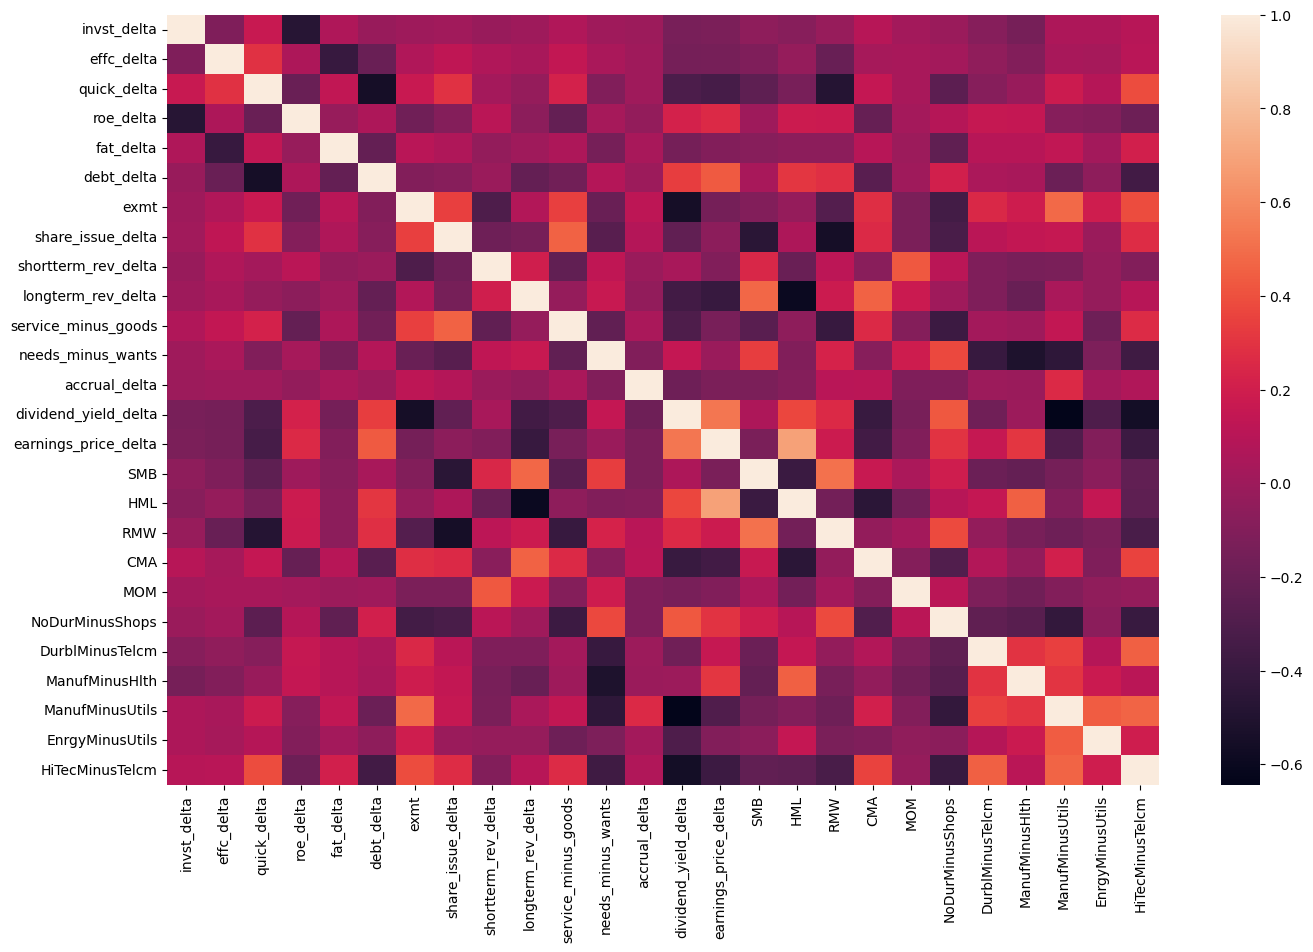

In [105]:
# Now that our dataset is complete, let's take a look at a correlation matrix:
plt.rcParams["figure.figsize"] = (16, 10)
sns.heatmap(subset_df.corr(), annot = False)
plt.show()

##### Everything looks really good. We have good VIF for our entire dataset, and our correlation matrix seems to not have anything multicollinear

## **SECTION 3:** Ordinary Least Squares

In [106]:
# Before regressing, let's just make some relevant lists based on how we constructed the dataframes:
fama_factors = ['SMB', 'HML', 'RMW', 'CMA', 'MOM']
alt_factors = ['share_issue_delta', 'shortterm_rev_delta', 'longterm_rev_delta', 'accrual_delta', 'dividend_yield_delta', 'earnings_price_delta']
built_factors = ['invst_delta', 'effc_delta', 'quick_delta', 'roe_delta', 'fat_delta', 'debt_delta']
hand_picked_industry_factors = ['service_minus_goods', 'needs_minus_wants']
post_lasso_industry_factors = ['NoDurMinusShops', 'DurblMinusTelcm', 'ManufMinusHlth', 'ManufMinusUtils', 'EnrgyMinusUtils', 'HiTecMinusTelcm']